# Digit Recognizer

data size: (32000, 784)
image_size => 784
image_width => 28
image_height => 28
dataset(32000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pix

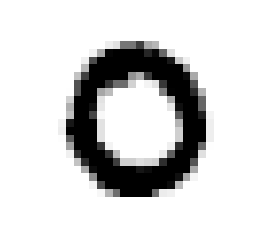

In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import logging
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
logging.getLogger("tf").setLevel(logging.WARNING)
dataset = pd.read_csv("train.csv")
target = dataset[[0]].values.ravel()
train = dataset.iloc[:,1:].values
test = pd.read_csv("test.csv").values
print('data size: (%g, %g)' % train.shape)
image_size = train.shape[1]
print ('image_size => {0}'.format(image_size))
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

print('dataset({0[0]},{0[1]})'.format(dataset.shape))
print (dataset.head())

def display(img):
    
    # (784) => (28x28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    
display(train[1])
a=np.zeros((len(target),10))
for i in range(0,len(target)):
    a[i][target[i]] = 1
num_examples = len(target)
index_in_epoch = 0
epochs_completed = 0
images = []
labels = []

def next_batch(batch_size):
    """Return the next `batch_size` examples from this data set."""
    global index_in_epoch, epochs_completed,images,labels,train,a
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_examples:
        # Finished epoch
        epochs_completed += 1
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train = train[perm]
        a = a[perm]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train[start:end], a[start:end]

In [14]:
VALIDATION_SIZE = 10000
# split data into training & validation
validation_images = train[:VALIDATION_SIZE]
validation_labels = a[:VALIDATION_SIZE]

train_images = train[VALIDATION_SIZE:]
train_labels = target[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(22000,784)
validation_images(10000,784)


In [15]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.global_variables_initializer())
y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [16]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
train_accuracies = []
validation_accuracies = []
x_range = []
for i in range(2000):
  batch = next_batch(50)
  if i%100 == 0:
    x_range.append(i)    
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    train_accuracies.append(train_accuracy)
    validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:50], y_: validation_labels[0:50], keep_prob: 1.0})
    validation_accuracies.append(validation_accuracy)
    print("step %d, training accuracy %g, validation accuracy %g"%(i, train_accuracy,validation_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

step 0, training accuracy 0.08, validation accuracy 0.08
step 100, training accuracy 0.86, validation accuracy 0.88
step 200, training accuracy 0.92, validation accuracy 0.88
step 300, training accuracy 1, validation accuracy 0.9
step 400, training accuracy 0.96, validation accuracy 0.92
step 500, training accuracy 0.96, validation accuracy 0.94
step 600, training accuracy 0.98, validation accuracy 0.94
step 700, training accuracy 0.92, validation accuracy 0.94
step 800, training accuracy 0.96, validation accuracy 0.94
step 900, training accuracy 0.94, validation accuracy 0.94
step 1000, training accuracy 0.94, validation accuracy 0.94
step 1100, training accuracy 0.98, validation accuracy 0.98
step 1200, training accuracy 0.92, validation accuracy 0.98
step 1300, training accuracy 0.98, validation accuracy 0.98
step 1400, training accuracy 1, validation accuracy 0.98
step 1500, training accuracy 0.94, validation accuracy 0.98
step 1600, training accuracy 0.94, validation accuracy 0.98

[ 6.  7.  0. ...,  7.  6.  9.]
validation_accuracy => 0.9788


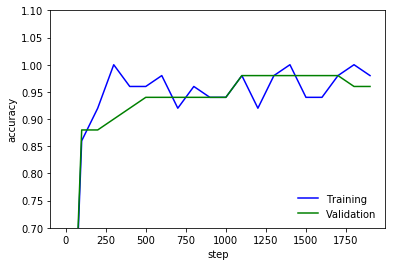

In [17]:
y_predict = []
for i in range(0, len(test), 100):
    y_temp = sess.run(tf.argmax(y_conv, 1), feed_dict={x: test[i:i + 100, :], keep_prob: 1.0})
    y_predict = np.append(y_predict, y_temp)
print(y_predict)
np.savetxt('digit_recognizer_op.csv', np.c_[range(1, len(test) + 1), y_predict], delimiter=',',
           header='imageid,label', comments='', fmt='%d')
validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
print('validation_accuracy => %.4f'%validation_accuracy)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, validation_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()
sess.close()